# MSE Computer Vision - Assignment 2

## Read image paths

In [1]:
import os

TRAIN_PATH = 'data/train2/'
VAL_PATH = 'data/val/'
TST_PATH = 'data/test/'

def path_names_list(path, name_snipped):
    return sorted([os.path.join(path, fname)
                   for fname in os.listdir(path)
                   if fname.endswith(".png") and name_snipped in fname])
    
train_img_paths = path_names_list(TRAIN_PATH, "train_img")
train_lbl_paths = path_names_list(TRAIN_PATH, "train_lbl")
val_img_paths = path_names_list(VAL_PATH, "val_img")
val_lbl_paths = path_names_list(VAL_PATH, "val_lbl")
tst_img_paths = path_names_list(TST_PATH, "test_img")
tst_lbl_paths = path_names_list(TST_PATH, "test_lbl")


print("Length training data:", len(train_img_paths), len(train_lbl_paths))
for n, (img_path, lbl_path) in enumerate(zip(train_img_paths, train_lbl_paths)):
    print(f"{img_path} -> {lbl_path}")
    if n == 3:
        print()
        break

print("Length validation data:", len(val_img_paths), len(val_lbl_paths))
for n, (img_path, lbl_path) in enumerate(zip(val_img_paths, val_lbl_paths)):
    print(f"{img_path} -> {lbl_path}")
    if n == 3:
        print()
        break
        
print("Length test data:", len(tst_img_paths), len(tst_lbl_paths))
for n, (img_path, lbl_path) in enumerate(zip(tst_img_paths, tst_lbl_paths)):
    print(f"{img_path} -> {lbl_path}")
    if n == 3:
        break


Length training data: 23520 23520
data/train2/train_img_000_00.png -> data/train2/train_lbl_000_00.png
data/train2/train_img_000_01.png -> data/train2/train_lbl_000_01.png
data/train2/train_img_000_02.png -> data/train2/train_lbl_000_02.png
data/train2/train_img_000_03.png -> data/train2/train_lbl_000_03.png

Length validation data: 8544 8544
data/val/val_img_000_00.png -> data/val/val_lbl_000_00.png
data/val/val_img_000_01.png -> data/val/val_lbl_000_01.png
data/val/val_img_000_02.png -> data/val/val_lbl_000_02.png
data/val/val_img_000_03.png -> data/val/val_lbl_000_03.png

Length test data: 30144 30144
data/test/test_img_000_00.png -> data/test/test_lbl_000_00.png
data/test/test_img_000_01.png -> data/test/test_lbl_000_01.png
data/test/test_img_000_02.png -> data/test/test_lbl_000_02.png
data/test/test_img_000_03.png -> data/test/test_lbl_000_03.png


## Dataloader

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle

IMG_SHAPE = 128

def normalize(image, mask):
  image = tf.cast(image, tf.float32) / 255.0
  mask += 1
  return image, mask

def load_and_preprocess(img_filepath, mask_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE])

    img, mask = normalize(img, mask)

    return img, mask


AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

train_img_paths, train_lbl_paths = shuffle(train_img_paths, train_lbl_paths, random_state=42)
val_img_paths, val_lbl_paths = shuffle(val_img_paths, val_lbl_paths, random_state=42)
tst_img_paths, tst_lbl_paths = shuffle(tst_img_paths, tst_lbl_paths, random_state=42)

trainloader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_lbl_paths))
valloader = tf.data.Dataset.from_tensor_slices((val_img_paths, val_lbl_paths))
tstloader = tf.data.Dataset.from_tensor_slices((tst_img_paths, tst_lbl_paths))



trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valloader = (
    valloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

tstloader = (
    tstloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2021-12-30 15:17:34.477126: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
labels = [
    #  name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    [  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ],
    [  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ],
    [  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ],
    [  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ],
    [  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ],
    [  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ],
    [  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ],
    [  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ],
    [  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ],
    [  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ],
    [  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ],
    [  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ],
    [  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ],
    [  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ],
    [  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ],
    [  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ],
    [  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ],
    [  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ],
    [  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ],
    [  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ],
    [  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ],
    [  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ],
    [  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ],
    [  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ],
    [  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ],
    [  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ],
    [  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ],
    [  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ],
    [  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ],
    [  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ],
    [  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ],
    [  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ],
    [  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ],
    [  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ],
    [  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ],
]

# segmentation_classes = [label[0] for label in labels]
SEGMENTATION_CLASSES_DICT = {n: label[0] for n, label in enumerate(labels) if label[0] != "license plate"}
SEGMENTATION_CLASSES_DICT[-1] = "license plate"

OUTPUT_CHANNEL = len(SEGMENTATION_CLASSES_DICT)
print(f"There are {OUTPUT_CHANNEL} segmentatin classes.")
print(SEGMENTATION_CLASSES_DICT)

There are 35 segmentatin classes.
{0: 'unlabeled', 1: 'ego vehicle', 2: 'rectification border', 3: 'out of roi', 4: 'static', 5: 'dynamic', 6: 'ground', 7: 'road', 8: 'sidewalk', 9: 'parking', 10: 'rail track', 11: 'building', 12: 'wall', 13: 'fence', 14: 'guard rail', 15: 'bridge', 16: 'tunnel', 17: 'pole', 18: 'polegroup', 19: 'traffic light', 20: 'traffic sign', 21: 'vegetation', 22: 'terrain', 23: 'sky', 24: 'person', 25: 'rider', 26: 'car', 27: 'truck', 28: 'bus', 29: 'caravan', 30: 'trailer', 31: 'train', 32: 'motorcycle', 33: 'bicycle', -1: 'license plate'}


## Visualize

2021-12-30 15:17:35.405760: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


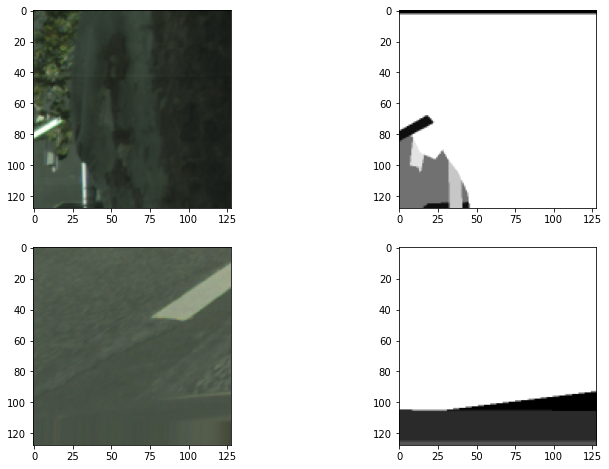

In [4]:
import matplotlib.pyplot as plt

num_example_to_display = 2
img, mask = next(iter(trainloader))
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  axs[i][0].imshow(img[i]);
  axs[i][1].imshow(np.squeeze(mask[i],-1), cmap='gray');

## Model

In [6]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import keras

In [7]:
def fcn_simple_no_border(input_height:int, input_width:int) -> keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    model = keras.Sequential()
    
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # add 3 convolutional layers with 3x3 filters
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))
    model.add(keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))
    
    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=1, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.Activation('sigmoid'))
    
    # reshape so that we have a sample for each pixel
    model.add(keras.layers.Reshape(target_shape=(input_height, input_width, 1)))
    
    return model

In [8]:
# ref: https://github.com/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb
class SegmentationModel:
  '''
  Build UNET based model for segmentation task.
  '''
  def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
    inputs = Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv9)

    return Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = concatenate([up, shared_layer], axis=3)

    return conv, up

def model_u(img_shape, output_channels):
    model = keras.Sequential()
    model.add(keras.layers.Layer(input_shape=(img_shape , img_shape, 3)))
    
    # down
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    # up
    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding='same'))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,2), padding='same'))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding='same'))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(2,2), padding='same'))
    
    model.add(Conv2D(output_channels, (3, 3), activation='softmax', padding='same'))
    
    return model

## Compile Model

In [9]:
tf.keras.backend.clear_session()
# model = SegmentationModel().prepare_model(OUTPUT_CHANNEL)
model = model_u(IMG_SHAPE, OUTPUT_CHANNEL)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

## Callbacks

In [13]:
# return dictionary with segmentation classes (key->number, value->name)
def labels():
    return SEGMENTATION_CLASSES_DICT

# util function for generating interactive image mask from components
def wandb_mask(bg_img, pred_mask, true_mask):
  return wandb.Image(bg_img, masks={
      "prediction" : {
          "mask_data" : pred_mask, 
          "class_labels" : labels()
      },
      "ground truth" : {
          "mask_data" : true_mask, 
          "class_labels" : labels()
      }
    }
  )

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

output_epoch_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')

# https://keras.io/api/callbacks/learning_rate_scheduler/

## Train

In [11]:
import wandb
from wandb.keras import WandbCallback

!wandb login

wandb: Currently logged in as: marcofuchs (use `wandb login --relogin` to force relogin)


In [ ]:
wandb.init(project='image-segmentation', reinit=True)

EPOCHS = 15

history = model.fit(trainloader, 
              epochs=EPOCHS, 
              validation_data=valloader,
              callbacks=[early_stopping_callback, WandbCallback(), output_epoch_callback])

wandb.finish()

Epoch 1/15
735/735 [==============================] - 2047s 3s/step - loss: 1.7250 - val_loss: 1.4266
Epoch 2/15
735/735 [==============================] - 55959s 76s/step - loss: 1.2832 - val_loss: 1.1239
Epoch 3/15
597/735 [=======================>......] - ETA: 21:41 - loss: 1.0749

wandb: Network error (ConnectionError), entering retry loop.


735/735 [==============================] - 7956s 11s/step - loss: 1.0597 - val_loss: 1.3577
Epoch 4/15
735/735 [==============================] - 15191s 21s/step - loss: 0.9607 - val_loss: 0.9250
Epoch 5/15
735/735 [==============================] - 2707s 4s/step - loss: 0.9093 - val_loss: 0.9043
Epoch 6/15
325/735 [============>.................] - ETA: 1:48:31 - loss: 0.8734

wandb: Network error (ConnectionError), entering retry loop.


735/735 [==============================] - ETA: 0s - loss: 0.8605 

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.


735/735 [==============================] - 14066s 19s/step - loss: 0.8605 - val_loss: 0.9249
Epoch 7/15
 61/735 [=>............................] - ETA: 1:39:28 - loss: 0.8063

wandb: Network error (ConnectionError), entering retry loop.


735/735 [==============================] - 74249s 101s/step - loss: 0.8079 - val_loss: 0.8335
Epoch 8/15
735/735 [==============================] - 3288s 4s/step - loss: 0.7687 - val_loss: 0.8218
Epoch 9/15
 99/735 [===>..........................] - ETA: 49:04 - loss: 0.7238

wandb: Network error (ConnectionError), entering retry loop.


735/735 [==============================] - 2509s 3s/step - loss: 0.7427 - val_loss: 0.8401
Epoch 10/15
207/735 [=======>......................] - ETA: 22:33 - loss: 0.7161

In [ ]:
# visualizing losses and accuracy

print(history.history.keys())

train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['acc']
val_acc    = history.history['val_acc']
xc         = range(EPOCHS)

plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)

## Prediction

In [ ]:
val_img, val_mask = next(iter(valloader))

pred_mask = model.predict(val_img)
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)

num_example_to_display = 10

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i]);
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray');
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')